# Materials Project Element Distribution by Arity

In [3]:
import dash
import pandas as pd
import plotly.io as pio
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
from plotly.graph_objs._figure import Figure
from pymatgen.ext.matproj import MPRester

from pymatviz import count_elements, ptable_heatmap, ptable_heatmap_plotly


pio.templates.default = "plotly_white"
# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but missing plots on GitHub!)
pio.renderers.default = "notebook"

In [ ]:
with MPRester() as mpr:
    mp_data = mpr.query(
        criteria={"nelements": {"$lte": 4}},
        properties=["material_id", "pretty_formula", "nelements"],
    )

df_mp = pd.DataFrame(mp_data).set_index("material_id")

In [4]:
# uncomment line to cache large MP data
# %store df_mp

# uncomment line to load cached MP data from disk
%store -r df_mp

In [5]:
elem_counts_by_arity = {
    label: count_elements(df_mp.query(f"nelements == {idx}").pretty_formula)
    for idx, label in enumerate(["binary", "ternary", "quaternary"], 2)
}

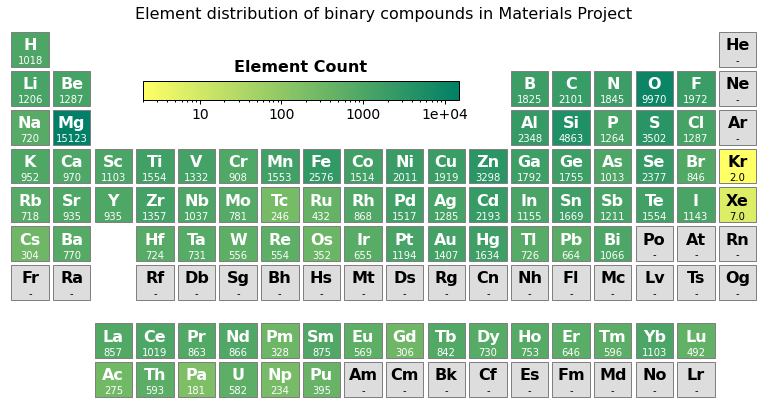

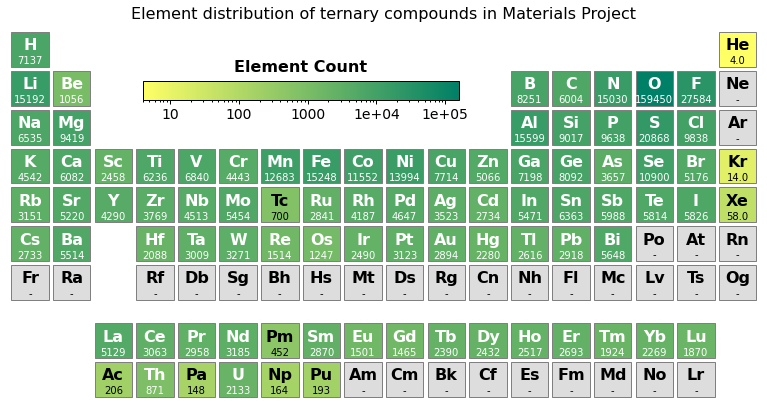

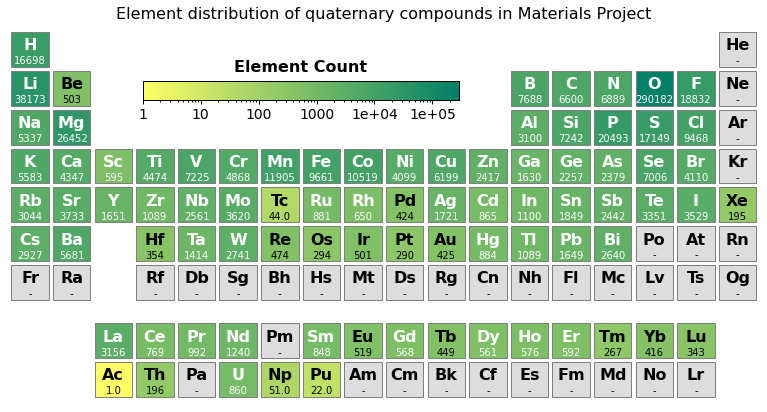

In [6]:
for arity_label, elem_counts in elem_counts_by_arity.items():
    ax = ptable_heatmap(elem_counts, log=True)
    ax.set_title(
        f"Element distribution of {arity_label} compounds in Materials Project",
        fontsize=16,
    )

In [7]:
arity_figs = {}
for arity_label, elem_counts in elem_counts_by_arity.items():
    fig = ptable_heatmap_plotly(
        elem_counts,
        hover_props=["atomic_number", "type"],
        heat_mode="percent",
    )

    title = (
        f"<b>Element distribution of <i>{arity_label}</i> compounds<br>"
        "in Materials Project</b>"
    )
    fig.update_layout(title=dict(text=title, x=0.45, y=0.9))
    arity_figs[arity_label] = fig
    # fig.show()  # uncomment to show plotly figures

In [8]:
app = JupyterDash(prevent_initial_callbacks=True)

graph = dash.dcc.Graph(figure=fig, id="ptable-heatmap", responsive=True)
dropdown = dash.dcc.Dropdown(
    id="arity-dropdown",
    options=[
        dict(label=arity_label, value=arity_label)
        for arity_label in elem_counts_by_arity
    ],
    style=dict(width="15em", margin="auto"),
    value="binary",
    placeholder="Select arity",
)
main_layout = dash.html.Div([dropdown, graph], style=dict(fontFamily="sans-serif"))
app.layout = main_layout


@app.callback(Output(graph.id, "figure"), Input(dropdown.id, "value"))
def update_figure(dropdown_value: str) -> Figure:
    """Update figure based on dropdown value."""

    fig = arity_figs[dropdown_value]
    return fig


app.run_server(debug=True, mode="inline")